## Классификация медицинских текстов


В набор данных включены аннотации по 5 различным заболеваниям:
  * болезни пищеварительной системы,
  * сердечно-сосудистые заболевания,
  * новообразования,
  * болезни нервной системы
  * общие патологические состояния.

### Импорт библиотек

In [1]:
 !pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, Layer, Dropout, SimpleRNN, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

from sklearn.metrics import classification_report


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_path = '/content/train.dat (1).zip'

In [7]:
# # Функция для распаковки архива в указанную папку
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/train.dat (1) (1).zip', 'r') as zip_ref:
    zip_ref.extractall()


### Загрузка датасета
 Проверка дисбаланса классов

In [9]:
df_train = pd.read_csv('/content/drive/MyDrive/train.dat (1) (1).zip', sep='\t', header=None )
df_train

,0,1
0,4,Catheterization laboratory events and hospital...
1,5,Renal abscess in children. Three cases of rena...
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,5,Subclavian artery to innominate vein fistula a...
4,4,Effect of local inhibition of gamma-aminobutyr...
...,...,...
14433,4,Quadricuspid aortic valve and aortic regurgita...
14434,1,Mammographic measurements before and after aug...
14435,1,Use of leukocyte-depleted platelet concentrate...
14436,2,Complications of Tenckhoff catheters post remo...


In [10]:
df_train.rename(columns = {0: 'class', 1: 'text'}, inplace=True)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14438 entries, 0 to 14437
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   14438 non-null  int64 
 1   text    14438 non-null  object
dtypes: int64(1), object(1)
memory usage: 225.7+ KB


In [12]:
df_train['class'].value_counts()

,count
class,
5,4805
1,3163
4,3051
3,1925
2,1494


In [13]:
classes = {1:'digestive system diseases',2:'cardiovascular diseases',3:'neoplasms',4:'nervous system diseases',5:'general pathological conditions'}

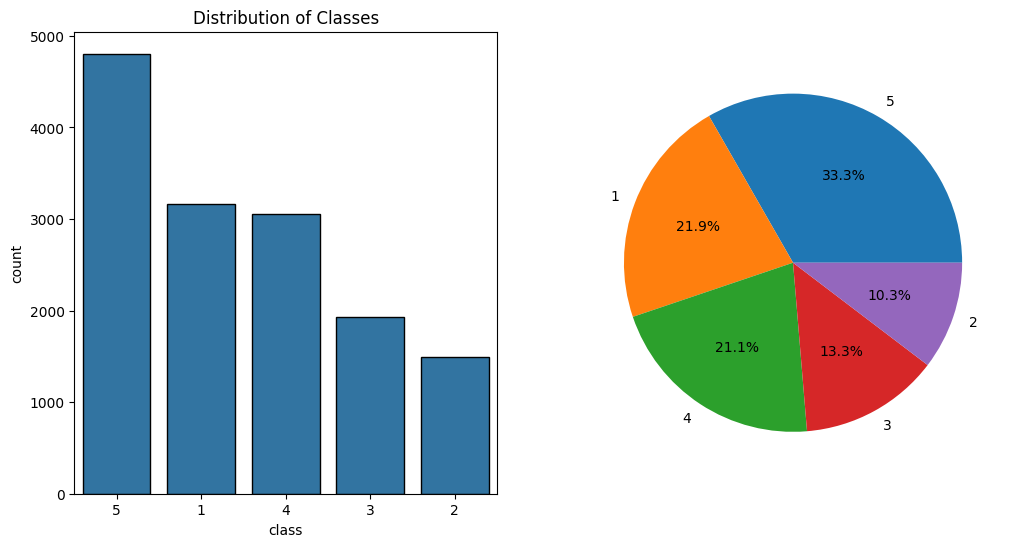

In [14]:
# распределение классов
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Distribution of Classes')
sns.countplot(x=df_train['class'], edgecolor='black', order=df_train['class'].value_counts().index)
plt.subplot(1,2,2)
plt.pie(x=df_train['class'].value_counts(), labels=df_train['class'].value_counts().index, autopct='%.1f%%')
plt.show()

### Подготовка данных для обучения и создание функции для отрисовки графиков

In [15]:
texts = df_train['text']
labels = df_train['class']
# Параметры
max_words = 5000
max_len = 200
embedding_dim = 100

# Токенизация и преобразование текстов в последовательности
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, maxlen=max_len)

# Преобразование меток в числовой формат
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = to_categorical(labels, num_classes=5)

# Разделение на тренировочную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [16]:
def show_train_eval_pred(history, model):

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Построение графиков ошибки
    ax[0].plot(history.history['loss'], label='Training Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Предсказания и матрица ошибок
    y_pred = model.predict(x_test)
    y_pred_classes = y_pred.argmax(axis=-1)
    y_true = y_test.argmax(axis=-1)
    cm = confusion_matrix(y_true, y_pred_classes)

    # Построение матрицы ошибок
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

### Модель Simple_RNN

In [ ]:
# Создание модели simple_RNN
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(SimpleRNN(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))

# Компиляция модели
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.2178 - loss: 1.6519 - val_accuracy: 0.3172 - val_loss: 1.5451
Epoch 2/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.2813 - loss: 1.5753 - val_accuracy: 0.3234 - val_loss: 1.5369
Epoch 3/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.3259 - loss: 1.5342 - val_accuracy: 0.3244 - val_loss: 1.5248
Epoch 4/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3425 - loss: 1.5040 - val_accuracy: 0.3348 - val_loss: 1.5180
Epoch 5/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.3538 - loss: 1.4887 - val_accuracy: 0.3407 - val_loss: 1.5129


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


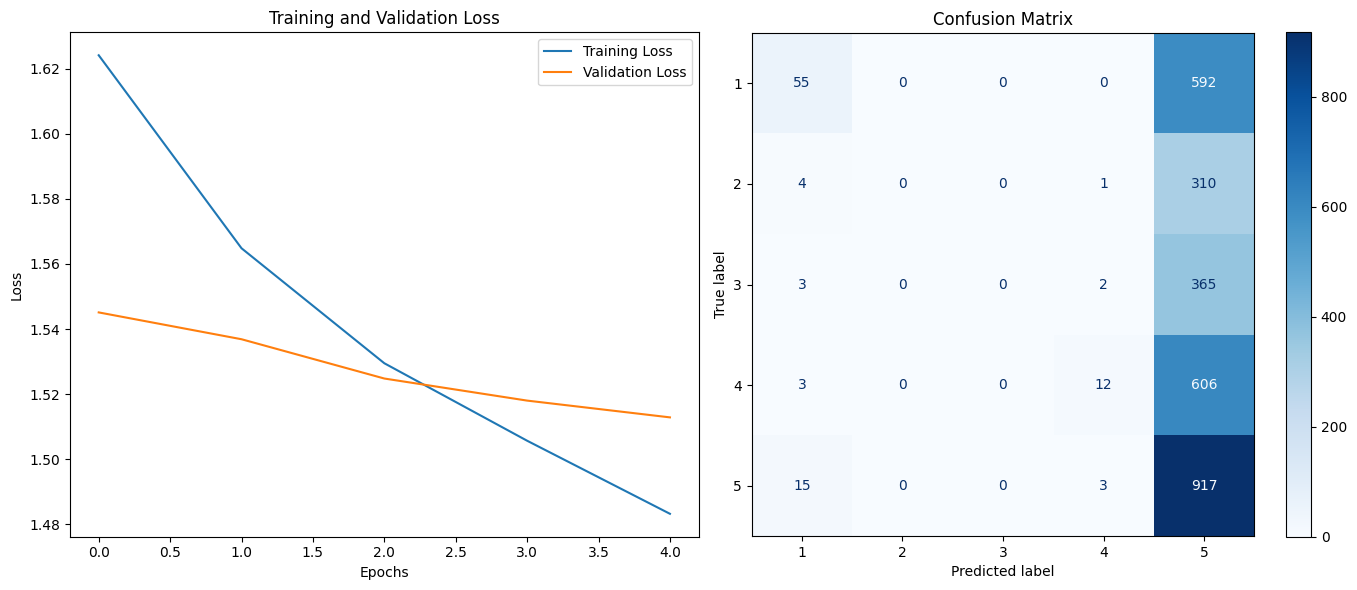

In [ ]:
show_train_eval_pred(history = history, model = model)

### Модель простой LSTM

In [ ]:
# Создание модели Простой LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_words, embedding_dim, input_length=max_len))
model_LSTM.add(SpatialDropout1D(0.2))
model_LSTM.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_LSTM.add(Dense(5, activation='softmax'))

# Компиляция модели
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели
history = model_LSTM.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


181/181 ━━━━━━━━━━━━━━━━━━━━ 132s 684ms/step - accuracy: 0.3457 - loss: 1.5118 - val_accuracy: 0.4765 - val_loss: 1.3277
Epoch 2/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 141s 696ms/step - accuracy: 0.4939 - loss: 1.2101 - val_accuracy: 0.5606 - val_loss: 1.1181
Epoch 3/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 137s 671ms/step - accuracy: 0.5849 - loss: 1.0142 - val_accuracy: 0.5526 - val_loss: 1.1045
Epoch 4/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 143s 676ms/step - accuracy: 0.6344 - loss: 0.8973 - val_accuracy: 0.5332 - val_loss: 1.1526
Epoch 5/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 140s 666ms/step - accuracy: 0.6591 - loss: 0.8432 - val_accuracy: 0.5301 - val_loss: 1.1844


91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step


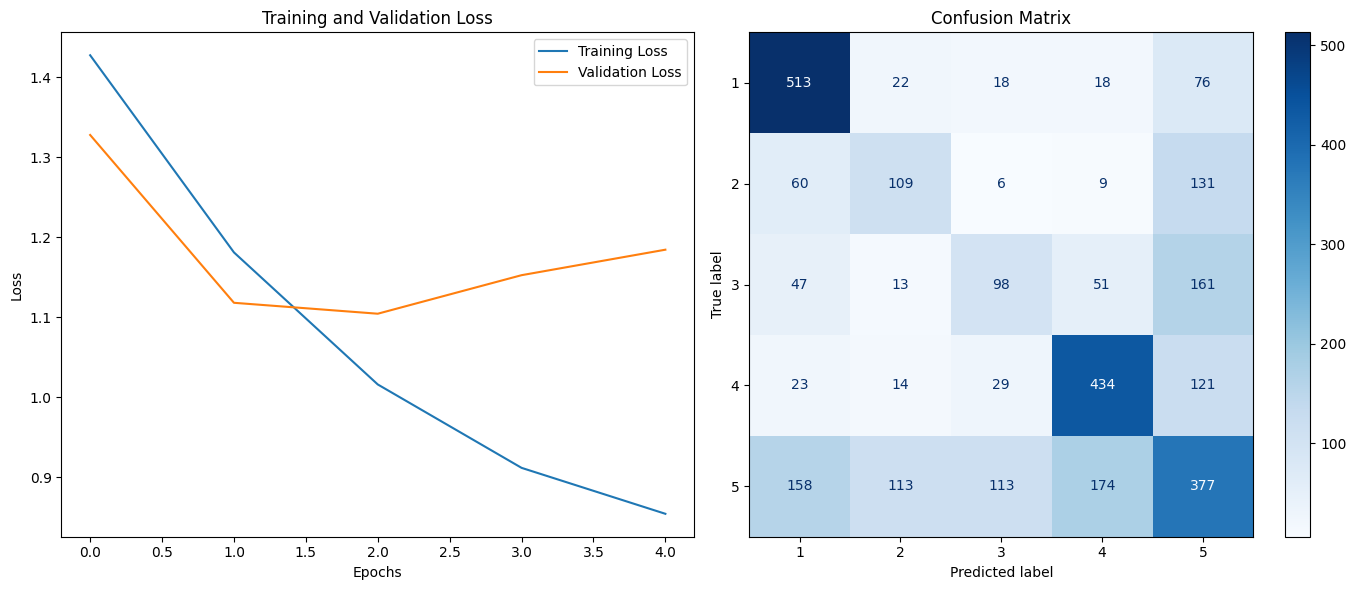

In [ ]:
show_train_eval_pred(history = history, model = model_LSTM)

### Модель CNN

In [ ]:
# Создание модели CNN
model_CNN = Sequential()
model_CNN.add(Embedding(max_words, embedding_dim, input_length=max_len))
model_CNN.add(Conv1D(128, 5, activation='relu'))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(5, activation='softmax'))

# Компиляция модели
model_CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели
history = model_CNN.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3404 - loss: 1.4960 - val_accuracy: 0.5336 - val_loss: 1.1525
Epoch 2/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5529 - loss: 1.0902 - val_accuracy: 0.6042 - val_loss: 0.9455
Epoch 3/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6163 - loss: 0.9153 - val_accuracy: 0.6136 - val_loss: 0.9150
Epoch 4/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6651 - loss: 0.8195 - val_accuracy: 0.5966 - val_loss: 0.9352
Epoch 5/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6897 - loss: 0.7610 - val_accuracy: 0.5744 - val_loss: 0.9643


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


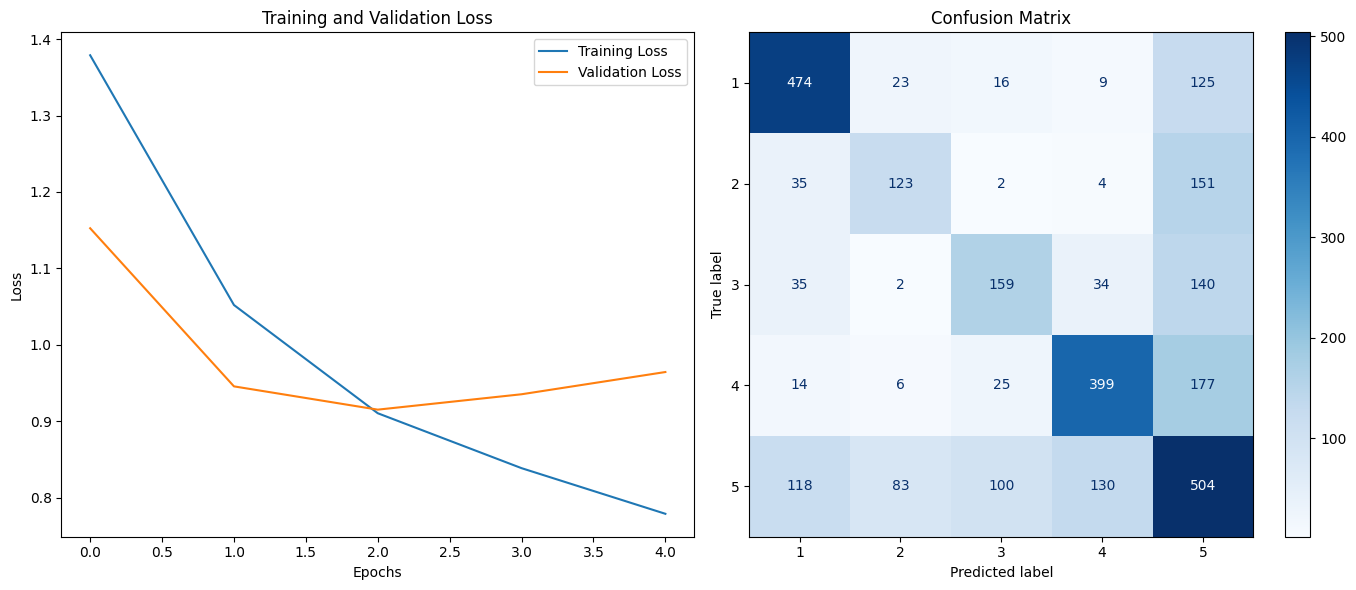

In [ ]:
show_train_eval_pred(history = history, model = model_CNN)

### Модель Bidirectional LSTM с Attention

 Долгосрочная краткосрочная память (LSTM) [https://www.sciencedirect.com/science/article/abs/pii/S0925231220300254]  
 Базовый блок LSTM сканирует только в одном направлении последовательности, Bidirectional LSTM двунаправленная долгосрочная краткосрочная память (BiLSTM)  является  дальнейшим развитием.
 BiLSTM сканирует в обоих направлениях последовательности, обеспечивая одновременный доступ как к прямому, так и к обратному контексту. Поэтому BiLSTM может решать задачи моделирования последовательностей лучше, чем LSTM.

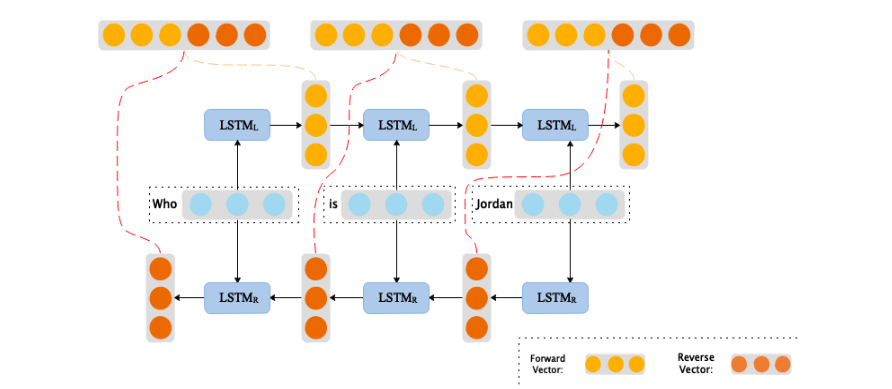

Bi-LSTM состоит из двух слоев LSTM: один обрабатывает последовательность от начала до конца (прямой LSTM), а другой обрабатывает ее от конца до начала (обратный LSTM) . Выходы из этих двух слоев затем объединяются или добавляются для формирования окончательного выходного представления для каждого временного шага.

Механизмы внимания  позволяют моделям динамически фокусироваться на определенных частях входной последовательности при генерации выходных данных.


Типы внимания:

Внимание методом скалярного произведения: вычисляет баллы внимания с использованием скалярного произведения векторов запроса и ключа, за которым следует функция softmax для получения нормализованных весов.

Аддитивное внимание: использует нейронную сеть прямого распространения для вычисления оценок внимания, которые затем нормализуются с помощью softmax.

Шаги по добавлению слоя внимания:

Определить модель Bi-LSTM
Рассчитать баллы внимания, используя методы скалярного произведения или аддитивные методы.
Применить функцию softmax к этим оценкам, чтобы получить веса внимания.
Вычислить вектор контекста как взвешенную сумму входных признаков, используя веса внимания.
Объединить выходы Bi-LSTM и Attention : объедините или добавьте вектор контекста к выходам Bi-LSTM, чтобы сформировать окончательное представление для каждого временного шага.
Выходной слой : полносвязный слой с соответствующей функцией активации (например, softmax для задач классификации) для получения окончательного вывода.

In [28]:
# Создание модели BiLSTM с Attention
class attention(Layer):

  #   Реализация механизма внимания для BiLSTM

    def __init__(self, return_sequences=False):
        self.return_sequences = return_sequences     #    Инициализация слоя Attention
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    def build(self, input_shape): #  считаем баллы внимания,
               # создание обучаемых весов для механизма внимания
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")   # инициализация нормальным распределением

        # b - вектор смещения для механизма внимания
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")

        super(attention,self).build(input_shape) # завершение построения слоя

    def call(self, x):

        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)  # преобразование оценок в веса внимания с помощью softmax
        output = x*a  # применение весов внимания к входным данным

        if self.return_sequences: # Возвращение результата в зависимости от параметра return_sequences
            return output

        return K.sum(output, axis=1)  # вычисление вектора контекста


model_BiLSTM = Sequential()
model_BiLSTM.add(Embedding(max_words, embedding_dim, input_length=max_len))
model_BiLSTM.add(Bidirectional(LSTM(100, return_sequences=True)))
model_BiLSTM.add(attention(return_sequences=False))
model_BiLSTM.add(Dropout(0.3))
model_BiLSTM.add(Dense(5, activation='softmax'))

# Компиляция модели
model_BiLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели
history = model_BiLSTM.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.3810 - loss: 1.4441 - val_accuracy: 0.5391 - val_loss: 1.1804
Epoch 2/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5420 - loss: 1.1265 - val_accuracy: 0.5720 - val_loss: 1.0490
Epoch 3/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6198 - loss: 0.9308 - val_accuracy: 0.5886 - val_loss: 0.9843
Epoch 4/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6763 - loss: 0.7945 - val_accuracy: 0.5907 - val_loss: 0.9877
Epoch 5/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7099 - loss: 0.7105 - val_accuracy: 0.5873 - val_loss: 1.0254


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


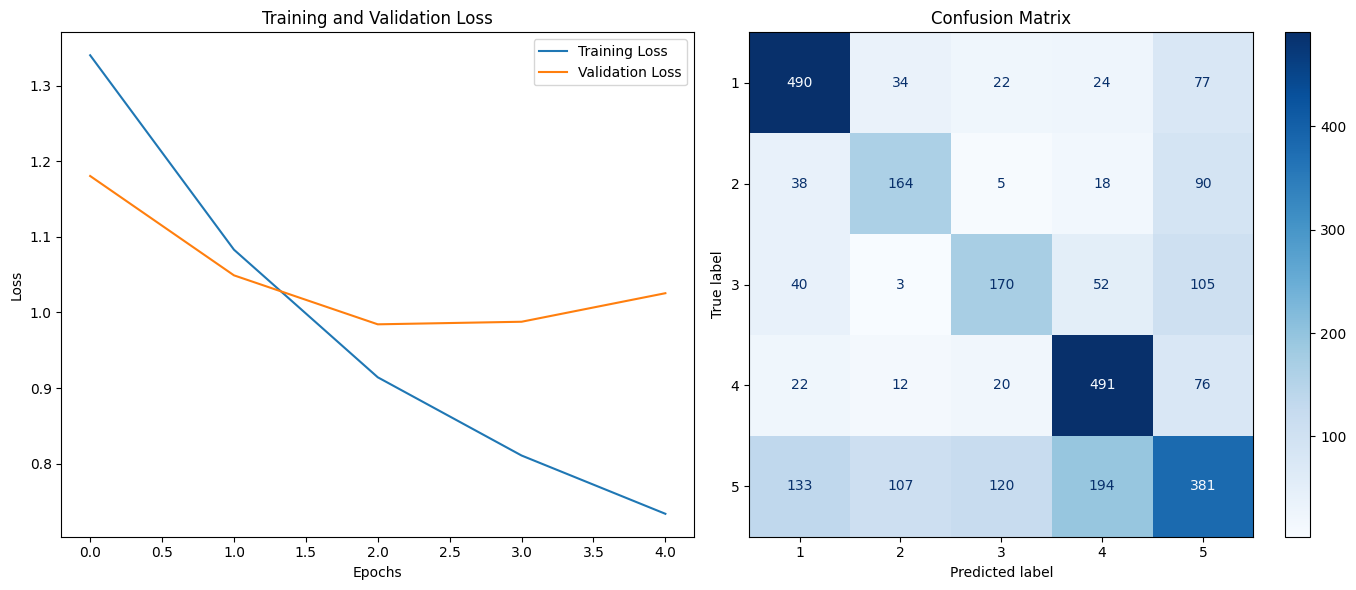

In [29]:
show_train_eval_pred(history = history, model = model_BiLSTM)

### Задание 1
1. Проверить работу лучшей модели на тестовых данных.
2. Повысить точность моделей, с использованием следующих методов

2.1 Предобработка данных
  * удаление стопслов
  * лемматизация и *стеминг*
2.2. Использование предобученные эмбединги GloVe вместо случайной инициализации эмбедингов
2.3. Оптимизация гиперпараметров:
  * Размер эмбеддингов
  * Число нейронов и слоев
  * Dropout
  * Пакетный размер и количество эпох


In [20]:
import pandas as pd
import zipfile

# распаковка
with zipfile.ZipFile('/content/drive/MyDrive/test.dat (1) (1).zip', 'r') as zip_ref:
    zip_ref.extractall('')

In [25]:
df_test = pd.read_csv('/content/drive/MyDrive/test.dat (1) (1).zip', sep='\t', header=None, names=['text'])
df_test

,text
0,Excision of limbal dermoids. We reviewed the c...
1,Bell's palsy. A diagnosis of exclusion. In cas...
2,Retained endobronchial foreign body removal fa...
3,Recurrent buccal space abscesses: a complicati...
4,Intracranial fibromatosis. Fibromatoses are un...
...,...
14437,Some genetic aspects of rolandic epilepsy: wak...
14438,IgM-associated primary diffuse mesangial proli...
14439,Immunohistochemical demonstration of neurone s...
14440,Rheumatoid iliopsoas bursitis presenting as un...


In [26]:
sequences_test = tokenizer.texts_to_sequences(df_test['text'])
x_test_final = pad_sequences(sequences_test, maxlen=max_len)

In [30]:
y_pred = model_BiLSTM.predict(x_test_final, batch_size=64)
pred_classes = y_pred.argmax(axis=1)

226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [31]:
pred_labels_num = label_encoder.classes_[pred_classes]  # [1..5]
classes_dict = {
    1: 'digestive system diseases',
    2: 'cardiovascular diseases',
    3: 'neoplasms',
    4: 'nervous system diseases',
    5: 'general pathological conditions'
}
pred_labels_str = [classes_dict[num] for num in pred_labels_num]


In [32]:
df_out = pd.DataFrame({
    'text': df_test['text'],
    'predicted_class_num': pred_labels_num,
    'predicted_class_name': pred_labels_str
})

In [33]:
df_out

,text,predicted_class_num,predicted_class_name
0,Excision of limbal dermoids. We reviewed the c...,1,digestive system diseases
1,Bell's palsy. A diagnosis of exclusion. In cas...,5,general pathological conditions
2,Retained endobronchial foreign body removal fa...,5,general pathological conditions
3,Recurrent buccal space abscesses: a complicati...,5,general pathological conditions
4,Intracranial fibromatosis. Fibromatoses are un...,1,digestive system diseases
...,...,...,...
14437,Some genetic aspects of rolandic epilepsy: wak...,5,general pathological conditions
14438,IgM-associated primary diffuse mesangial proli...,5,general pathological conditions
14439,Immunohistochemical demonstration of neurone s...,1,digestive system diseases
14440,Rheumatoid iliopsoas bursitis presenting as un...,3,neoplasms


In [34]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join(w for w in text.split() if w.lower() not in stop_words)

df_train['text_clean'] = df_train['text'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def stem_text(text):
    return ' '.join(ps.stem(w) for w in text.split())

df_train['text_stemmed'] = df_train['text_clean'].apply(stem_text)


In [38]:
!wget http://nlp.stanford.edu/data/glove.6B.zip -O /content/glove.6B.zip

--2025-05-20 11:27:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-20 11:27:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-20 11:27:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/glove.6B.z

In [39]:
!unzip -q /content/glove.6B.zip -d /content/

In [40]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word, coeffs = values[0], np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

In [41]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if idx < max_words and word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]


In [54]:
!pip install -q keras-tuner

import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, Layer
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

# 1) Attention-слой остаётся без изменений
class attention(Layer):
    def __init__(self, return_sequences=False):
        super(attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias",  shape=(input_shape[1], 1), initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return output if self.return_sequences else K.sum(output, axis=1)

# 2) Сохранили заранее embedding_matrix_100d (max_words × 100)
#    tokenizer, x_train, y_train, x_test, y_test, max_len уже есть.

class MedicalHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()

        # Размер эмбеддингов
        embed_dim = hp.Choice('embed_dim', [50, 100])
        emb_matrix = embedding_matrix_100d[:, :embed_dim]
        model.add(Embedding(input_dim=max_words,
                            output_dim=embed_dim,
                            embeddings_initializer=Constant(emb_matrix),
                            input_length=max_len,
                            trainable=True))

        # Число BiLSTM-слоёв и нейронов
        n_layers = hp.Int('n_layers', 1, 3)
        for i in range(n_layers):
            units = hp.Int(f'lstm_units_{i}', 50, 200, step=50)
            model.add(Bidirectional(LSTM(units, return_sequences=True)))

        # Attention + Dropout
        model.add(attention(return_sequences=False))
        dropout_rate = hp.Float('dropout_rate', 0.2, 0.6, step=0.1)
        model.add(Dropout(dropout_rate))

        # Выход
        model.add(Dense(5, activation='softmax'))

        # Компиляция с lr
        lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    def run_trial(self, trial, x, y, **fit_kwargs):
        # Подбор batch_size и epochs здесь
        batch_size = trial.hyperparameters.Choice('batch_size', [32, 64, 128])
        epochs     = trial.hyperparameters.Int('epochs', 5, 15, step=5)
        fit_kwargs['batch_size'] = batch_size
        fit_kwargs['epochs']     = epochs
        fit_kwargs['callbacks']  = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        ]
        super(MedicalHyperModel, self).run_trial(trial, x, y, **fit_kwargs)

# 3) Создаём и запускаем RandomSearch
tuner = RandomSearch(
    MedicalHyperModel(),
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='med_text'
)

tuner.search(x_train, y_train,
             validation_data=(x_test, y_test))

# 4) Извлекаем лучшие параметры и модель
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("Лучшие гиперпараметры:")
for k, v in best_hps.values.items():
    print(f"  {k}: {v}")

# Оценим на тесте
loss, acc = best_model.evaluate(x_test, y_test)
print(f"Финальная точность на валидации: {acc:.4%}")


Trial 20 Complete [00h 00m 14s]
val_accuracy: 0.5055401921272278

Best val_accuracy So Far: 0.6340027451515198
Total elapsed time: 00h 07m 45s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Лучшие гиперпараметры:
  embed_dim: 100
  n_layers: 1
  lstm_units_0: 50
  dropout_rate: 0.30000000000000004
  learning_rate: 0.01
  lstm_units_1: 100
  lstm_units_2: 100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6409 - loss: 0.8867
Финальная точность на валидации: 63.4003%


## Задание 2

1.	Создать нейронную сеть  по классификации текстов авторов (Writers.zip).
2.	Использовать различные методы предобратотки данных. Создайте   3 архитектуры сети  Conv1D, LSTM,  BiLSTM с Attention.
3.	Добейтесь результата точности сети не менее 95% средней точности распознавания по классам на модели Bag of Words и 65% - для модели Embedding.


In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional, Layer, Flatten
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


In [2]:
import zipfile
import os
import shutil

zip_path = "/content/drive/MyDrive/writers (1).zip"
extract_dir = "writers_data_2"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for info in zip_ref.infolist():
        try:
            # Попробуем декодировать имя вручную
            name = info.filename.encode('cp437').decode('cp866')  # или попробуй cp866
        except:
            name = info.filename  # fallback
        target_path = os.path.join(extract_dir, name)
        os.makedirs(os.path.dirname(target_path), exist_ok=True)
        with zip_ref.open(info) as source, open(target_path, "wb") as target:
            shutil.copyfileobj(source, target)


In [12]:
texts_train, labels_train = [], []
texts_test, labels_test = [], []

for fname in os.listdir(extract_dir):
    if fname.endswith('.txt'):
        author = fname.replace('.txt', '')
        filepath = os.path.join(extract_dir, fname)
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    if 'Обучающая' in fname:
                        texts_train.append(line)
                        labels_train.append(author)
                    elif 'Тестовая' in fname:
                        texts_test.append(line)
                        labels_test.append(author)

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [13]:
def preprocess_texts(texts, remove_stop=True, stemming=False, lemmatize=False):
    clean_texts = []
    for doc in texts:
        tokens = nltk.word_tokenize(doc.lower())
        if remove_stop:
            tokens = [w for w in tokens if w not in stop_words and w.isalpha()]
        if stemming:
            tokens = [ps.stem(w) for w in tokens]
        if lemmatize:
            tokens = [lemmatizer.lemmatize(w) for w in tokens]
        clean_texts.append(' '.join(tokens))
    return clean_texts

In [14]:
texts_train = preprocess_texts(texts_train, remove_stop=True, lemmatize=True)
texts_test = preprocess_texts(texts_test, remove_stop=True, lemmatize=True)

In [16]:
# Создаём множество авторов из обучающей выборки
train_authors_set = set(labels_train)

# Фильтруем тестовые тексты и метки, оставляя только те, что есть в обучающей выборке
filtered_texts_test = []
filtered_labels_test = []

for text, label in zip(texts_test, labels_test):
    if label in train_authors_set:
        filtered_texts_test.append(text)
        filtered_labels_test.append(label)

texts_test = filtered_texts_test
labels_test = filtered_labels_test

# Теперь можно делать transform без ошибки
y_test = en.transform(labels_test)


In [17]:
en = LabelEncoder()
y_train = en.fit_transform(labels_train)
y_test = en.transform(labels_test)

In [18]:
vectorizer = CountVectorizer(max_features=5000)
X_train_bow = vectorizer.fit_transform(texts_train).toarray()
X_test_bow = vectorizer.transform(texts_test).toarray()

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_bow = Sequential([
    Input(shape=(X_train_bow.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(len(en.classes_), activation='softmax')
])

model_bow.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

model_bow.fit(
    X_train_bow, y_train,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)



Epoch 1/30
976/976 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4472 - loss: 1.5809 - learning_rate: 5.0000e-04
Epoch 2/30
 23/976 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7244 - loss: 1.0345

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


976/976 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7135 - loss: 1.0398 - learning_rate: 5.0000e-04
Epoch 3/30
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7420 - loss: 0.9676 - learning_rate: 5.0000e-04
Epoch 4/30
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7592 - loss: 0.9259 - learning_rate: 5.0000e-04
Epoch 5/30
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7670 - loss: 0.9006 - learning_rate: 5.0000e-04
Epoch 6/30
976/976 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7770 - loss: 0.8810 - learning_rate: 5.0000e-04
Epoch 7/30
976/976 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7834 - loss: 0.8612 - learning_rate: 5.0000e-04
Epoch 8/30
976/976 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7917 - loss: 0.8442 - learning_rate: 5.0000e-04
Epoch 9/30
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8023 - loss: 0.8255 - learning_rate: 5.0000e-04
Epoch 10/30
976/976 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8080 - loss: 0.8117 - learning_r

In [24]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional, Layer, Flatten, Multiply, Permute, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# --- Предположим, что у тебя уже есть тексты и метки, разделённые как ниже ---
texts_train, labels_train = [], []
texts_test, labels_test = [], []

for fname in os.listdir('writers_data_2'):
    if fname.endswith('.txt'):
        author = fname.replace('.txt', '')
        with open(os.path.join('writers_data_2', fname), 'r', encoding='utf-8') as f:
            lines = f.readlines()
        if 'Обучающая' in fname:
            for line in lines:
                line = line.strip()
                if line:
                    texts_train.append(line)
                    labels_train.append(author)
        elif 'Тестовая' in fname:
            for line in lines:
                line = line.strip()
                if line:
                    texts_test.append(line)
                    labels_test.append(author)

all_labels = labels_train + labels_test
en = LabelEncoder()
en.fit(all_labels)

y_train = en.transform(labels_train)
y_test = en.transform(labels_test)

max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_train)

X_train_seq = tokenizer.texts_to_sequences(texts_train)
X_test_seq = tokenizer.texts_to_sequences(texts_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_dim = 100

In [43]:
'(Стругацкие) Тестовая_2 вместе' in labels_test

True

In [41]:
print("Названия классов в y_train:")
print([en.classes_[i] for i in sorted(set(y_train))])

print("\nНазвания классов в y_test:")
print([en.classes_[i] for i in sorted(set(y_test))])


Названия классов в y_train:
[np.str_('(Булгаков) Обучающая_5 вместе'), np.str_('(Клиффорд_Саймак) Обучающая_5 вместе'), np.str_('(Макс Фрай) Обучающая_5 вместе'), np.str_('(О. Генри) Обучающая_50 вместе'), np.str_('(Рэй Брэдберри) Обучающая_22 вместе'), np.str_('(Стругацкие) Обучающая_5 вместе')]

Названия классов в y_test:
[np.str_('(Булгаков) Тестовая_2 вместе'), np.str_('(Клиффорд_Саймак) Тестовая_2 вместе'), np.str_('(Макс Фрай) Тестовая_2 вместе'), np.str_('(О. Генри) Тестовая_20 вместе'), np.str_('(Рэй Брэдберри) Тестовая_8 вместе'), np.str_('(Стругацкие) Тестовая_2 вместе')]


In [25]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        e = tf.keras.backend.squeeze(e, axis=-1)
        alpha = tf.keras.backend.softmax(e)
        alpha = tf.keras.backend.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = tf.keras.backend.sum(context, axis=1)
        return context

In [26]:
  def create_conv1d_model():
      inputs = Input(shape=(max_len,))
      x = Embedding(vocab_size, embedding_dim, input_length=max_len)(inputs)
      x = Conv1D(128, 5, activation='relu')(x)
      x = GlobalMaxPooling1D()(x)
      x = Dense(64, activation='relu')(x)
      x = Dropout(0.4)(x)
      outputs = Dense(len(en.classes_), activation='softmax')(x)
      model = Model(inputs, outputs)
      return model

In [27]:
def create_lstm_model():
    inputs = Input(shape=(max_len,))
    x = Embedding(vocab_size, embedding_dim, input_length=max_len)(inputs)
    x = LSTM(128)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(len(en.classes_), activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [28]:
def create_bilstm_attention_model():
    inputs = Input(shape=(max_len,))
    x = Embedding(vocab_size, embedding_dim, input_length=max_len)(inputs)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Attention()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(len(en.classes_), activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [47]:
import tensorflow as tf

class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_acc = logs.get('accuracy')
        train_loss = logs.get('loss')
        print(f"Epoch {epoch+1}: loss = {train_loss:.4f}, accuracy = {train_acc:.4f}")

def compile_and_train(model, X_train, y_train, epochs=5, batch_size=64):
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.1, verbose=0,
                        callbacks=[Callback()])
    return history

In [48]:
conv1d_model = create_conv1d_model()
lstm_model = create_lstm_model()
bilstm_att_model = create_bilstm_attention_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [49]:
print("Обучаем Conv1D модель")
compile_and_train(conv1d_model, X_train_pad, y_train)

print("Обучаем LSTM модель")
compile_and_train(lstm_model, X_train_pad, y_train)

print("Обучаем BiLSTM + Attention модель")
compile_and_train(bilstm_att_model, X_train_pad, y_train)

Обучаем Conv1D модель
Epoch 1: loss = 0.8834, accuracy = 0.6754
Epoch 2: loss = 0.4182, accuracy = 0.8562
Epoch 3: loss = 0.2860, accuracy = 0.9032
Epoch 4: loss = 0.2025, accuracy = 0.9313
Epoch 5: loss = 0.1471, accuracy = 0.9499
Обучаем LSTM модель
Epoch 1: loss = 1.6741, accuracy = 0.3337
Epoch 2: loss = 1.6247, accuracy = 0.3432
Epoch 3: loss = 1.6202, accuracy = 0.3438
Epoch 4: loss = 1.6176, accuracy = 0.3442
Epoch 5: loss = 1.6156, accuracy = 0.3442
Обучаем BiLSTM + Attention модель
Epoch 1: loss = 1.2172, accuracy = 0.5394
Epoch 2: loss = 0.5881, accuracy = 0.7959
Epoch 3: loss = 0.4228, accuracy = 0.8553
Epoch 4: loss = 0.3305, accuracy = 0.8881
Epoch 5: loss = 0.2652, accuracy = 0.9100
